In [63]:
install.packages("ggplot2")
install.packages("dplyr")
install.packages("glmnet")


The downloaded binary packages are in
	/var/folders/91/4c3th19d31j6hvx23r6bb5b00000gn/T//RtmpLyr87d/downloaded_packages

The downloaded binary packages are in
	/var/folders/91/4c3th19d31j6hvx23r6bb5b00000gn/T//RtmpLyr87d/downloaded_packages

The downloaded binary packages are in
	/var/folders/91/4c3th19d31j6hvx23r6bb5b00000gn/T//RtmpLyr87d/downloaded_packages


In [64]:
library(dplyr)
library(glmnet)

# Import and format data

In [65]:
#read in the data
data <- read.csv("/Users/User/Documents/GitHub/DesktopDownthrottlingExperiment/post_experiment/Regression_2_(web_to_serviceable)/regression_tables/fieldwork_regression_table.csv")
data$scaled_score <- data$score_min/5
data$scaled_score <- pmax(pmin(data$scaled_score, 0.9999), 0.0001)
data$logistic_transformed_score <- log(data$scaled_score / (1 - data$scaled_score))
trim_data <- data %>% select(-identifier,-score_min, - scaled_score,  -serviceable_agg, -score_ellen, -score_aadya, -serviceable_ellen, -serviceable_aadya)

# Build a model

In [110]:
model <- lm(logistic_transformed_score ~ ., data = trim_data)
fit_aic <- step(model)

Start:  AIC=-46.6
logistic_transformed_score ~ IT01V_packetsRecieved_ellen + IT01V_packetsRecieved_aadya + 
    IT01V_packetsLost_ellen + IT01V_packetsLost_aadya + IT01V_frameWidth_ellen + 
    IT01V_frameWidth_aadya + IT01V_frameHeight_ellen + IT01V_frameHeight_aadya + 
    IT01V_totalFreezesDuration_ellen + IT01V_totalFreezesDuration_aadya + 
    IT01V_framesPerSecond_ellen + IT01V_framesPerSecond_aadya + 
    IT01V_bytesReceived_in_bits_s_ellen + IT01V_bytesReceived_in_bits_s_aadya + 
    IT01V_totalProcessingDelay_ellen + IT01V_totalProcessingDelay_aadya + 
    IT01V_jitter_ellen + IT01V_jitter_aadya + IT01V_jitterBufferDelay_emissions_ellen + 
    IT01V_jitterBufferDelay_emissions_aadya + IT01A_bytesReceived_in_bits_s_ellen + 
    IT01A_bytesReceived_in_bits_s_aadya + IT01A_jitterBufferDelay_emissions_ellen + 
    IT01A_jitterBufferDelay_emissions_aadya + OT01V_packetsSent_s_ellen + 
    OT01V_packetsSent_s_aadya + OT01V_bytesSent_in_bits_s_ellen + 
    OT01V_bytesSent_in_bits_s_a

# import data

In [97]:
stage_1 <- read.csv("/Users/User/Documents/GitHub/DesktopDownthrottlingExperiment/post_experiment/Regression_2_(web_to_serviceable)/regression_tables/stage_1_regression_table.csv")
stage_2 <- read.csv("/Users/User/Documents/GitHub/DesktopDownthrottlingExperiment/post_experiment/Regression_2_(web_to_serviceable)/regression_tables/stage_2_regression_table.csv")
stage_3 <- read.csv("/Users/User/Documents/GitHub/DesktopDownthrottlingExperiment/post_experiment/Regression_2_(web_to_serviceable)/regression_tables/stage_3_regression_table.csv")

# infer values

In [98]:
predicted_scores_1 <- predict(fit_aic, newdata = stage_1)
stage_1$score <- predicted_scores_1
predicted_scores_2 <- predict(fit_aic, newdata = stage_2)
stage_2$score <- predicted_scores_2
predicted_scores_3 <- predict(fit_aic, newdata = stage_3)
stage_3$score <- predicted_scores_3

## model of inferred score to up/down/rtt

In [109]:
new_model1<- lm(score ~ log(Upload) + log(Download) + Latency, data = stage_1)
new_model2 <- lm(score ~ log(Upload) + log(Download) + Latency, data = stage_2)
new_model3 <- lm(score ~ log(Upload_x) + log(Download_x) + Latency_x + log(Upload_y) + log(Download_y) + Latency_y, data = stage_3)
#summary(new_model1)
#summary(new_model2)
summary(new_model3)


Call:
lm(formula = score ~ log(Upload_x) + log(Download_x) + Latency_x + 
    log(Upload_y) + log(Download_y) + Latency_y, data = stage_3)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.0259 -0.4606  0.0648  0.6381  2.7577 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -1.6947893  0.8883814  -1.908  0.05743 .  
log(Upload_x)    0.1467223  0.0453206   3.237  0.00135 ** 
log(Download_x)  0.0379987  0.0566560   0.671  0.50296    
Latency_x       -0.0009079  0.0002909  -3.121  0.00199 ** 
log(Upload_y)    0.1805594  0.0456321   3.957 9.59e-05 ***
log(Download_y) -0.1263315  0.0569362  -2.219  0.02728 *  
Latency_y        0.0035773  0.0002909  12.297  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.106 on 286 degrees of freedom
Multiple R-squared:  0.4106,	Adjusted R-squared:  0.3982 
F-statistic:  33.2 on 6 and 286 DF,  p-value: < 2.2e-16


# undo the logistic transform

In [101]:
transform_scores <- function(stage_data) {
  stage_data$real_score <- exp(stage_data$score) / (1 + exp(stage_data$score))
  stage_data$real_score_multiplied <- stage_data$real_score * 5
  return(stage_data)
}
stage_1 <- transform_scores(stage_1)
stage_2 <- transform_scores(stage_2)
stage_3 <- transform_scores(stage_3)

# add a binary column that defines serviceability

In [102]:
create_binary_grouping <- function(stage_data) {
  stage_data$binary_col <- ifelse(stage_data$real_score_multiplied < 3, 0, 1)
  
  unserv_0 <- subset(stage_data, binary_col == 0)
  serv_1 <- subset(stage_data, binary_col == 1)
  
  unserv_0$group <- paste("UNSERV")
  serv_1$group <- paste("SERV")
  
  combined_data <- rbind(unserv_0, serv_1)
  return(combined_data)
}
#execute for each stage
combined_data1 <- create_binary_grouping(stage_1)
combined_data2 <- create_binary_grouping(stage_2)
combined_data3 <- create_binary_grouping(stage_3)

In [104]:
#show distribution of 0s and 1s
table(combined_data1$binary_col)
table(combined_data2$binary_col)
table(combined_data3$binary_col)


  0   1 
293   6 


  0   1 
 60 232 


  0   1 
 88 205 

# create factors for up and latency

In [106]:
create_factors <- function(data) {
    upload_levels <- c(500, 1000, 5000, 20000)
    latency_levels <-  c(100, 250, 400, 550, 750)
    data$Upload_Factor <- factor(data$Upload, levels = upload_levels)
    data$Latency_Factor <- factor(data$Latency, levels = latency_levels)
  return(data)
}

combined_data1 <- create_factors(combined_data1)
combined_data2 <- create_factors(combined_data2)
# combined_data3 <- create_factors(combined_data3)  #need to change this to account for upload_x, upload_y


# visualise

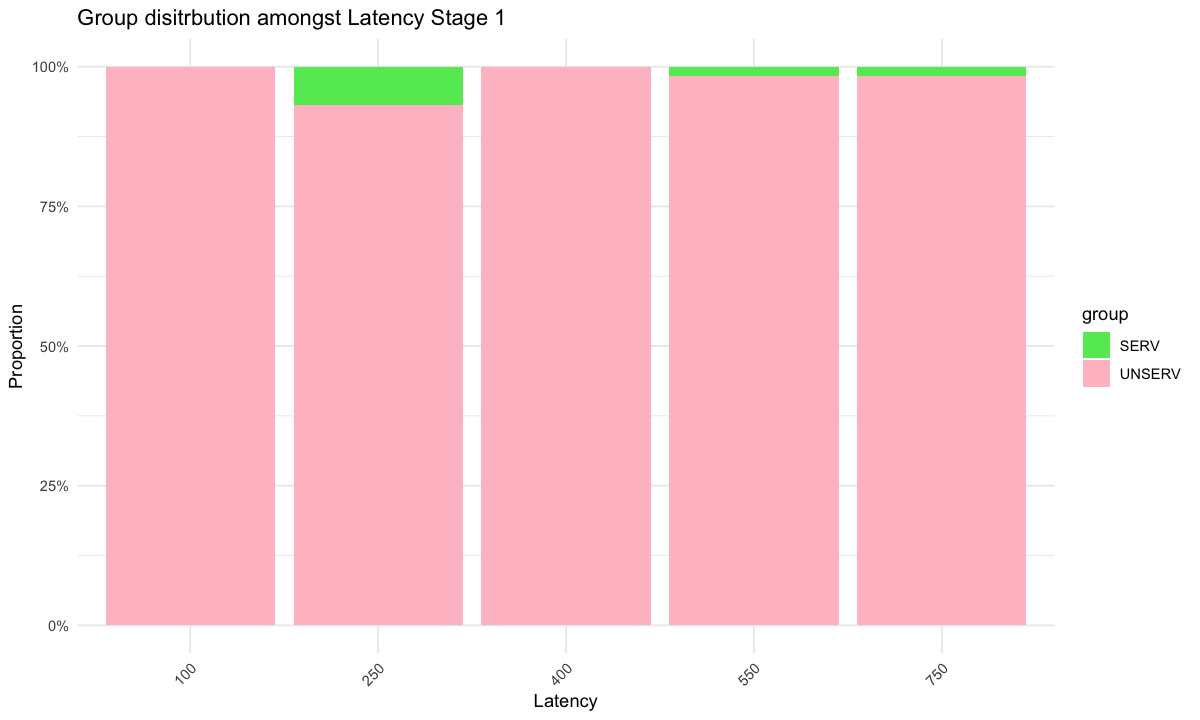

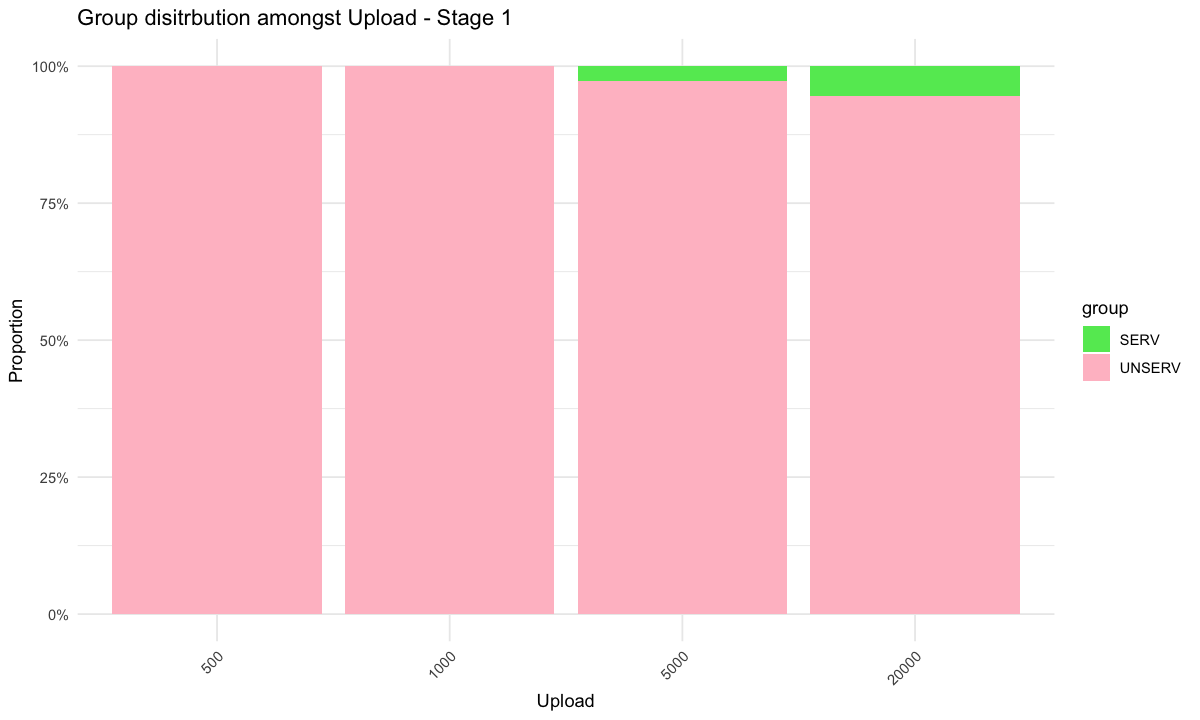

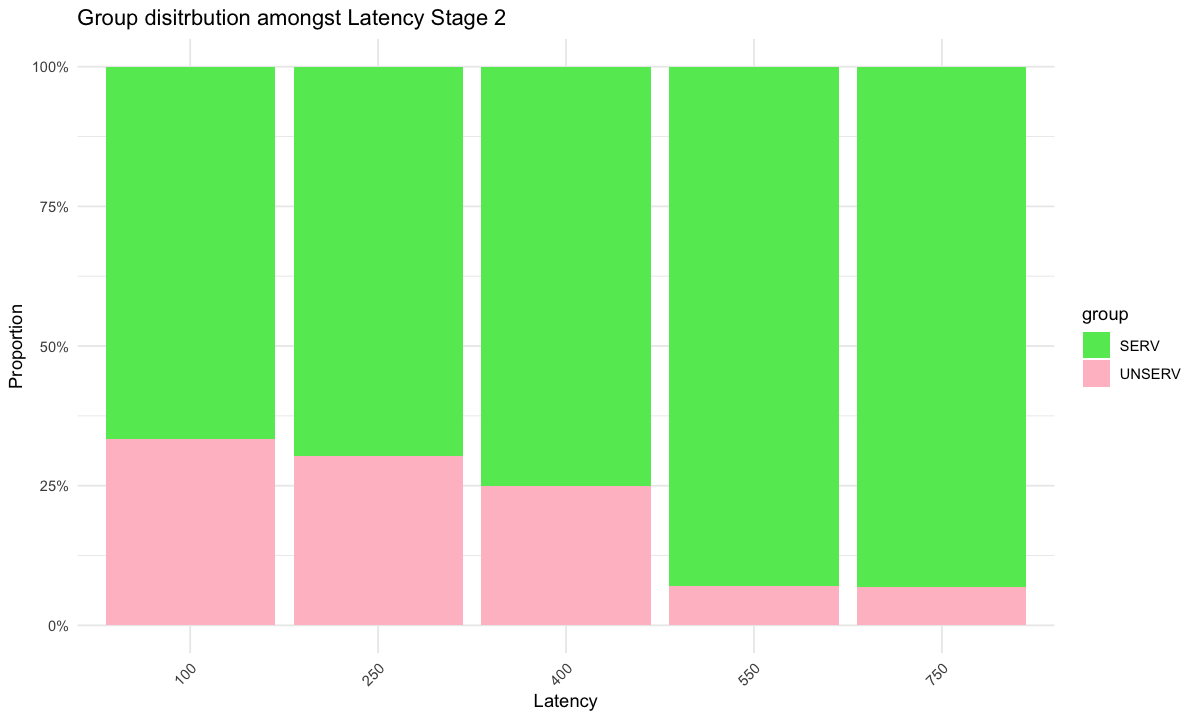

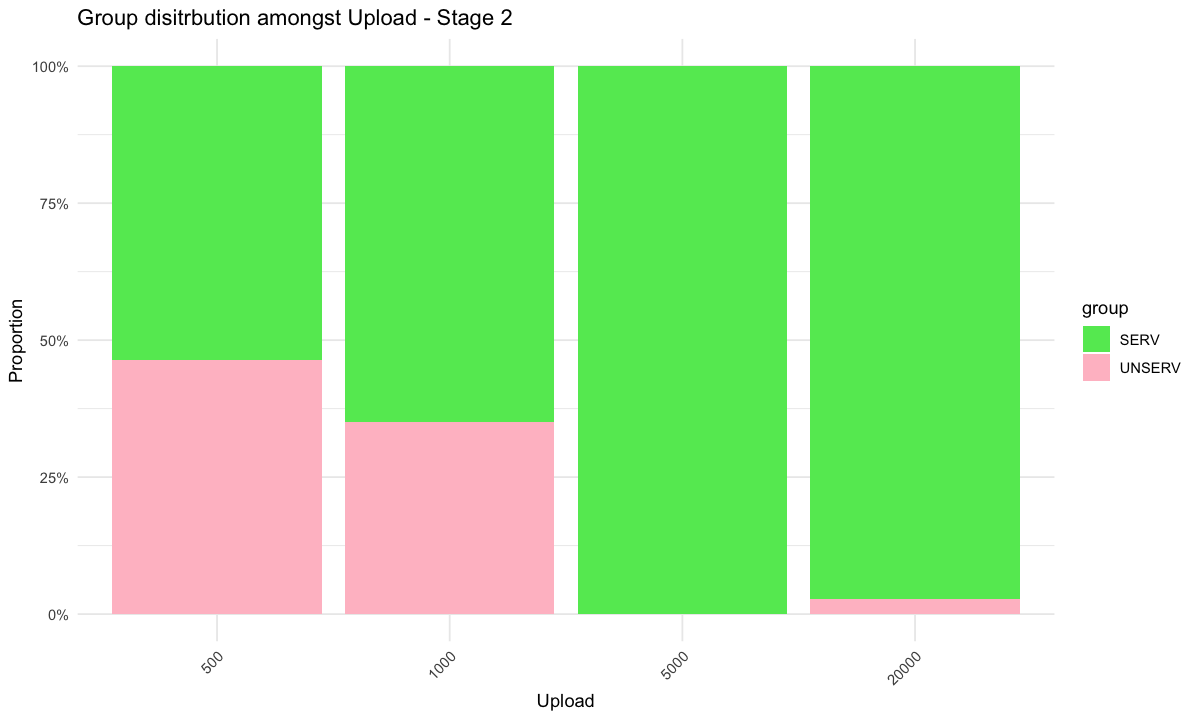

In [111]:
library(ggplot2)

plot_grouped_stacked_bars <- function(data, stage_name) {
  custom_colors <- c("UNSERV" = "pink", "SERV" = "#61e861")
  options(repr.plot.width = 10, repr.plot.height = 6)

  # Plot for Latency Factor
  p1 <- ggplot(data, aes(x = Latency_Factor, fill = group)) +
    geom_bar(position = "fill") +  # Stacked bar with proportions
    labs(title = paste("Group disitrbution amongst Latency", stage_name),
         x = "Latency",
         y = "Proportion") +
    scale_y_continuous(labels = scales::percent) +  # Format y-axis as percentage
    scale_fill_manual(values = custom_colors) + 
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) 

  # Plot for Upload Factor
  p2 <- ggplot(data, aes(x = Upload_Factor, fill = group)) +
    geom_bar(position = "fill") +  # Stacked bar with proportions
    labs(title = paste("Group disitrbution amongst Upload -", stage_name),
         x = "Upload",
         y = "Proportion") +
    scale_y_continuous(labels = scales::percent) +
    scale_fill_manual(values = custom_colors) + 
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

  return(list(latency_plot = p1, upload_plot = p2))
}

#make plots
plots_stage_1 <- plot_grouped_stacked_bars(combined_data1, "Stage 1")
plots_stage_2 <- plot_grouped_stacked_bars(combined_data2, "Stage 2")
#plots_stage_3 <- plot_grouped_stacked_bars(combined_data3, "Stage 3")

#print plots
print(plots_stage_1$latency_plot)
print(plots_stage_1$upload_plot)

print(plots_stage_2$latency_plot)
print(plots_stage_2$upload_plot)

# print(plots_stage_3$latency_plot)
# print(plots_stage_3$upload_plot)
